# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [13]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions

In [14]:

from jaxns.special_priors import Bernoulli
from jaxns import Prior, Model

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p, name='predicates')
    return predicates, p[1]


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & 0.6 <= P(b) <= 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    #0.6 <= P(b) <= 0.9
    log_prob_1 = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9))
    log_prob_2 = jnp.where((p_B < 0.6) | (p_B > 0.9), -jnp.inf, 0.)
    log_prop = log_prob_1 + log_prob_2

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2023-07-05 01:48:40,257]: Sanity check...
INFO[2023-07-05 01:48:40,260]: Sanity check passed


In [15]:
from jaxns import ExactNestedSampler, TerminationCondition

# Run the nested sampling
ns = ExactNestedSampler(model=model, num_live_points=2000, max_samples=1e5)

term_reason, state = ns(random.PRNGKey(3452345), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = ns.to_results(state, termination_reason=term_reason)

--------
Termination Conditions:
Small remaining evidence
All live-points are on a single plateau (potential numerical errors, consider 64-bit)
--------
# likelihood evals: 14793
# samples: 4000
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 3.7
# likelihood evals / slice: nan
--------
logZ=-0.3645 +- 0.0093
H=1.2
ESS=1776
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.46 +- 0.28 | 0.08 / 0.45 / 0.87 | 0.05 | 0.66
p[1]: 0.751 +- 0.087 | 0.628 / 0.754 / 0.87 | 0.863 | 0.815
p[2]: 0.52 +- 0.3 | 0.1 / 0.54 / 0.92 | 0.01 | 0.96
--------
predicates[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2023-07-05 01:48:49,637]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicates[0]: 0.35 +- 0.48 | 0.0 / 0.0 / 1.0 | 0.0 | 0.0
predicates[1]: 0.77 +- 0.42 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
predicates[2]: 0.58 +- 0.49 | 0.0 / 1.0 / 1.0 | 0.0 | 1.0
--------


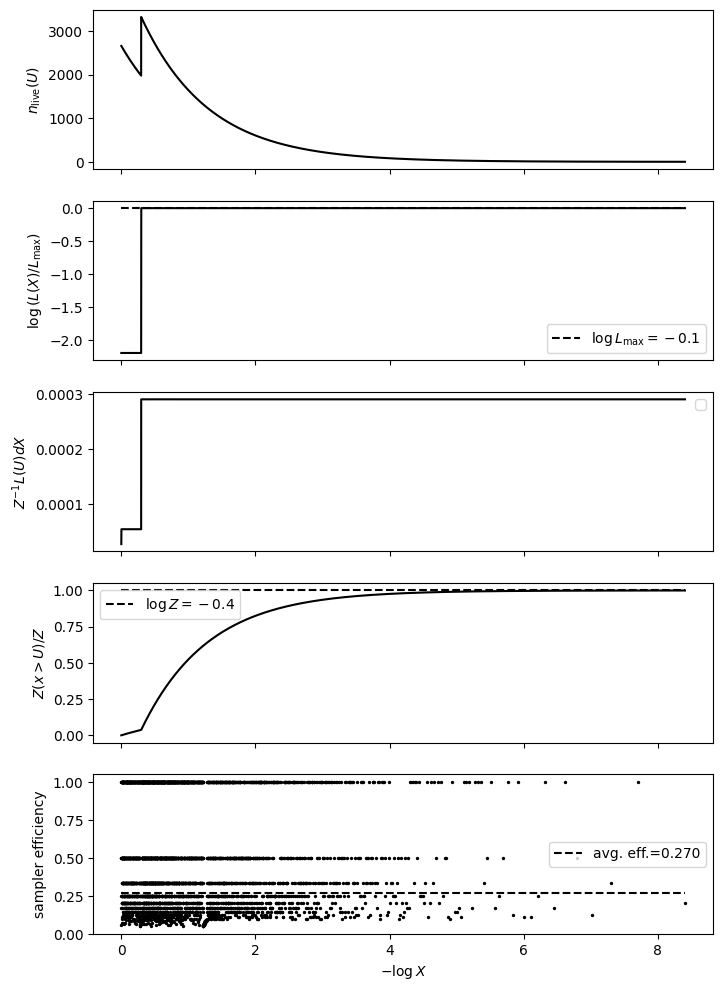

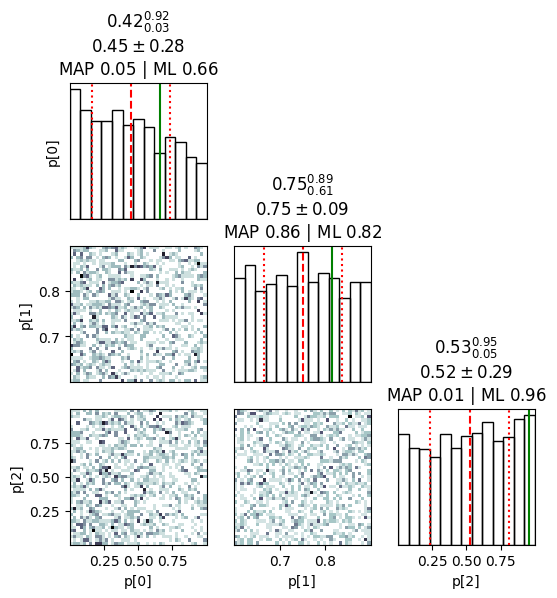

In [16]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results, vars=['p', 'p_B'])